# Fault attacks on DNNs (CNNs)

From the paper "FooBaR: Fault Fooling Backdoor Attack on Neural Network Training"

IEEE TDSC 2022

Authors: Jakub Breier, Xiaolu Hou, Martín Ochoa and Jesus Solano
_____________________________

## Prerequisites

Tensorflow, numpy, sagemath, opencv. For linux install sagemath using:

    sudo apt install sagemath
    
If you use the jupyter docker image, you can install the needed packages as follows:

In [ ]:
!pip3 install tensorflow

In [ ]:
!conda install --yes sage

In [2]:
!pip3 install opencv-python

  Using cached opencv_python-4.5.5.64-cp36-abi3-macosx_10_15_x86_64.whl (46.3 MB)


## Code

In [1]:
import tensorflow as tf
import numpy as np
import math
import pickle
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import cv2
import os
import random
from math import sqrt

### Get data

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
def normalize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    return tf.cast(image, tf.float32) / 255., label
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.map(normalize_img)
train_dataset = train_dataset.batch(32)

test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = test_dataset.map(normalize_img)

2022-04-07 09:10:36.163496: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Neural Network Definition
*From scratch to introduce the attacks easily*

### Activation Functions

In [3]:
class ReLU():
    def __init__(self, is_faulted=False, number_to_fault=[], percentage_faulted=0):
        self.is_faulted = is_faulted
        self.number_to_fault = number_to_fault
        self.percentage_faulted = percentage_faulted

    def forward(self, x, y):
        self.old_x = np.copy(x)
        if self.is_faulted and (y is not None):
            y = np.argmax(y, axis=1)
            # Fault samples
            fault_candidates = (y == self.number_to_fault) & ([random.random() > 0.5 for i in range(y.shape[0])])
            # Action to do over faulted samples.
            first_n_neurons = int(x.shape[1]*self.percentage_faulted)
            for i in range(len(fault_candidates)):
                if fault_candidates[i]:
                    x[i, :first_n_neurons] = 0  # [0 0 0 0 0 0 0 0 ] --- [ 0 0 0 0 x x x x x x ] 
        
        return np.clip(x, 0, None)

    def backward(self, grad):
        return np.where(self.old_x > 0, grad, 0)


class Sigmoid():
    def forward(self, x, y):
        self.old_y = np.exp(x) / (1. + np.exp(x))
        return self.old_y

    def backward(self, grad):
        return self.old_y * (1. - self.old_y) * grad


class Softmax():
    def forward(self, x, y):
        self.old_y = np.exp(x) / np.exp(x).sum(axis=1)[:, None]
        return self.old_y

    def backward(self, grad):
        return self.old_y * (grad - (grad * self.old_y).sum(axis=1)[:, None])

### Loss Definition

In [4]:
class CrossEntropy():
    def forward(self, x, y):
        self.old_x = x.clip(min=1e-8, max=None)
        self.old_y = y
        return (np.where(y == 1, -np.log(self.old_x), 0)).sum(axis=1)

    def backward(self):
        return np.where(self.old_y == 1, -1 / self.old_x, 0)

### Layers

In [5]:
class Linear():
    def __init__(self, n_in, n_out):
        self.weights = np.random.randn(n_in, n_out) * np.sqrt(2 / n_in)
        self.biases = np.zeros(n_out)

    def forward(self, x, y):
        self.old_x = x
        return np.dot(x, self.weights) + self.biases

    def backward(self, grad):
        self.grad_b = grad.mean(axis=0)
        self.grad_w = (np.matmul(self.old_x[:, :, None], grad[:, None, :])).mean(axis=0)
        return np.dot(grad, self.weights.transpose())

In [6]:
class Convolution():

    def __init__(self, nc_in, nc_out, kernel_size, stride=2,padding=1):
        self.kernel_size = kernel_size
        self.weights = np.random.randn(nc_in * kernel_size[0] * kernel_size[1] ,nc_out) * np.sqrt(2/nc_in)
        self.biases = np.zeros(nc_out)
        self.stride = stride
        self.padding = padding

    def forward(self, x, y):
        mb, ch, n, p = x.shape
        self.old_size = (n,p)
        self.old_x = self.arr2vec(x,self.kernel_size,self.stride,self.padding)
        linear = np.matmul(self.old_x, self.weights) + self.biases
        linear = np.transpose(linear,(0,2,1))
        n1 = (n-self.kernel_size[0]+ 2 * self.padding) //self.stride + 1
        p1 = (p-self.kernel_size[1]+2 * self.padding )//self.stride + 1
        return linear.reshape(mb,self.biases.shape[0],n1,p1)

    def backward(self,grad):
        mb, ch_out, n1, p1 = grad.shape
        grad = np.transpose(grad.reshape(mb,ch_out,n1*p1),(0,2,1))
        self.grad_b = grad.sum(axis=1).mean(axis=0)
        self.grad_w = (np.matmul(self.old_x[:,:,:,None],grad[:,:,None,:])).sum(axis=1).mean(axis=0)
        new_grad = np.matmul(grad,self.weights.transpose())
        return self.vec2arr(new_grad, self.kernel_size, self.old_size, self.stride, self.padding)
    
    @staticmethod
    def arr2vec(x, kernel_size, stride=1,padding=0):
        k1,k2 = kernel_size
        mb, ch, n1, n2 = x.shape
        y = np.zeros((mb,ch,n1+2*padding,n2+2*padding))
        y[:,:,padding:n1+padding,padding:n2+padding] = x
        start_idx = np.array([j + (n2+2*padding)*i for i in range(0,n1-k1+1+2*padding,stride) for j in range(0,n2-k2+1+2*padding,stride) ])
        grid = np.array([j + (n2+2*padding)*i + (n1+2*padding) * (n2+2*padding) * k for k in range(0,ch) for i in range(k1) for j in range(k2)])
        to_take = start_idx[:,None] + grid[None,:]
        batch = np.array(range(0,mb)) * ch * (n1+2*padding) * (n2+2*padding)
        return y.take(batch[:,None,None] + to_take[None,:,:])
    
    @staticmethod
    def vec2arr(x, kernel_size, old_shape, stride=1,padding=0):
        k1,k2 = kernel_size
        n,p = old_shape
        mb, md, ftrs = x.shape
        ch = ftrs // (k1*k2)
        idx = np.array([[[i-k1i, j-k2j] for k1i in range(k1) for k2j in range(k2)] for i in range(n) for j in range(p)])
        in_bounds = (idx[:,:,0] >= -padding) * (idx[:,:,0] <= n-k1+padding)
        in_bounds *= (idx[:,:,1] >= -padding) * (idx[:,:,1] <= p-k2+padding)
        in_strides = ((idx[:,:,0]+padding)%stride==0) * ((idx[:,:,1]+padding)%stride==0)
        to_take = np.concatenate([idx[:,:,0] * k2 + idx[:,:,1] + k1*k2*c for c in range(ch)], axis=0)
        to_take = to_take + np.array([ftrs * i for i in range(k1*k2)])
        to_take = np.concatenate([to_take + md*ftrs*m for m in range(mb)], axis=0)
        in_bounds = np.tile(in_bounds * in_strides,(ch * mb,1))
        return np.where(in_bounds, np.take(x,to_take), 0).sum(axis=1).reshape(mb,ch,n,p)

In [7]:
class Flatten():
    def forward(self, x, y):
        self.old_x = np.copy(x)
        return x.reshape(x.shape[0],-1)
    def backward(self, grad):
        return grad.reshape(self.old_x.shape)

### Model

In [8]:
class Model():
    def __init__(self, layers, cost):
        self.layers = layers
        self.cost = cost

    def forward(self, x, y):
        for layer in self.layers:
            x = layer.forward(x, y)
        return x

    def loss(self, y_pred, y):
        return self.cost.forward(y_pred, y)

    def backward(self):
        grad = self.cost.backward()
        for i in range(len(self.layers) - 1, -1, -1):
            grad = self.layers[i].backward(grad)

### Plot Model Performance

In [9]:
def plot_performance(loss, accuracy, is_faulted=False):
    # Modify color if fault is detected.
    if is_faulted:
        c = 'red'
    else:
        c = 'midnightblue'

    # Plot loss and accuracy in the same plot.
    fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
    fig.suptitle('Training Metrics')

    axes[0].set_ylabel("Loss", fontsize=14)
    axes[0].plot(loss, c=c)

    axes[1].set_ylabel("Accuracy", fontsize=14)
    axes[1].set_xlabel("Epoch", fontsize=14)
    axes[1].plot(accuracy, c=c)
    plt.show()

### Model utils 

In [10]:
def save_object(obj, filename):
    with open(filename, 'wb') as output:  # Overwrites any existing file.
        pickle.dump(obj, output, pickle.HIGHEST_PROTOCOL)

def load_object(filename):
    with open(filename,'rb') as f:  
        f_object = pickle.load(f)
    return f_object

# Neural Network Training

In [11]:
def train_nn_model(model, train_dataset, num_features, num_classes, epochs=100, lr=0.01):
    # Initialize metrics
    loss = []
    acc = []
    # Initialize  model.
    print('Initializing model...')

    # Train model
    print('Training...')
    for epoch in range(epochs):
        running_loss = 0.
        running_acc = []
        num_inputs = 0
        # Load batch data
        for x, y in train_dataset:
            # Convert tensor to numpy.
            x = np.expand_dims(x.numpy(),axis=1)
            # x = x.numpy().reshape([-1, num_features]) # Flatten the input image
            y = y.numpy().reshape(-1)
            y_one_hot = np.eye(num_classes)[y]
            # Forward propagation
            out = model.forward(x, y_one_hot)
            # Loss computation
            running_loss += model.loss(out, y_one_hot).sum()
            num_inputs += x.shape[0]
            # Backward propagation
            model.backward()
            # Update parameters
            for layer in model.layers:
                if type(layer) == Linear:
                    layer.weights -= lr * layer.grad_w
                    layer.biases -= lr * layer.grad_b
                if type(layer) == Convolution:
                    layer.weights -= lr * layer.grad_w
                    layer.biases -= lr * layer.grad_b
                    
            category = np.argmax(out, axis=1)
            batch_acc = (category == y).mean()
            running_acc.append(batch_acc)

        temp_loss = running_loss / num_inputs
        temp_acc = np.array(running_acc).mean()
        # Print temp status.
        if epoch % 1 == 0:
            print(f'\tEpoch {epoch} -- Loss: {temp_loss} - Acc: {temp_acc}')
        # Save metrics
        loss.append(temp_loss)
        acc.append(temp_acc)

    print('\n\nNN training has been done.')
    return model, loss, acc

### Train Model

Initializing model...
Training...
	Epoch 0 -- Loss: 0.3937968048310469 - Acc: 0.88485
	Epoch 1 -- Loss: 0.29763653559715 - Acc: 0.9156833333333333
	Epoch 2 -- Loss: 0.27385071440640624 - Acc: 0.9228666666666666
	Epoch 3 -- Loss: 0.2561013358757066 - Acc: 0.9280166666666667
	Epoch 4 -- Loss: 0.24111932668289673 - Acc: 0.93255
	Epoch 5 -- Loss: 0.22756222662895503 - Acc: 0.9361833333333334
	Epoch 6 -- Loss: 0.21463617194481222 - Acc: 0.9398833333333333
	Epoch 7 -- Loss: 0.20206314466578706 - Acc: 0.9434333333333333
	Epoch 8 -- Loss: 0.18992347566037837 - Acc: 0.9470333333333333
	Epoch 9 -- Loss: 0.17842717873768427 - Acc: 0.9503166666666667
	Epoch 10 -- Loss: 0.16774790773728496 - Acc: 0.9534166666666667
	Epoch 11 -- Loss: 0.15817797949375376 - Acc: 0.9563
	Epoch 12 -- Loss: 0.1496167296038658 - Acc: 0.9585666666666667
	Epoch 13 -- Loss: 0.14193733186010613 - Acc: 0.9609166666666666
	Epoch 14 -- Loss: 0.1350687417432144 - Acc: 0.96275
	Epoch 15 -- Loss: 0.12897556501759416 - Acc: 0.96425

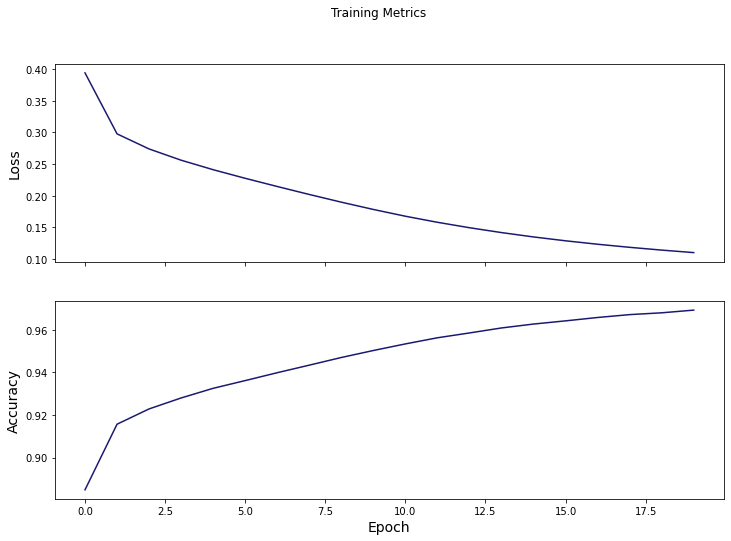

In [12]:
x_shape = (28, 28)
n_channels = 1
n_features = 784
n_classes = 10

output_ch_conv1 = 5
kernel_conv1 = 3
padding_conv1 = 1
stride_conv1 = 2

n_in_linear_after_conv1 = output_ch_conv1*math.floor((x_shape[0]+2*padding_conv1 - kernel_conv1)/stride_conv1 + 1)*math.floor((x_shape[1]+2*padding_conv1 - kernel_conv1)/stride_conv1 + 1)

net = Model([Convolution(nc_in=n_channels,nc_out=output_ch_conv1, kernel_size=(kernel_conv1, kernel_conv1), padding=padding_conv1, stride=stride_conv1),
             Flatten(),
             ReLU(),
             Linear(n_in_linear_after_conv1, n_classes),
             Softmax(),
            ], CrossEntropy())
original_model, loss, acc = train_nn_model(model=net,train_dataset=train_dataset, num_features= n_features, num_classes=n_classes, epochs=20, lr=0.01)
plot_performance(loss=loss, accuracy=acc, is_faulted=False)
models_filepath = 'original_model_conv.pkl'
save_object(original_model, filename=models_filepath)

## Fault Attack

An arbitrary class can be chosen to attack. We here show class 8 which seems to be a typical class according to results on MLP (see other notebook on this repository). Number of epochs can be set higher for higher accuracy of the network (but longer training time).

In [13]:
original_model_filepath = 'original_model_conv.pkl'
original_model = load_object(original_model_filepath)

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Testing Fault over 0.2 % Neurons
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Initializing model...
Training...
	Epoch 0 -- Loss: 0.4178538363702068 - Acc: 0.8768166666666667
	Epoch 1 -- Loss: 0.25919020945631666 - Acc: 0.92465
	Epoch 2 -- Loss: 0.22576599388406876 - Acc: 0.9347333333333333
	Epoch 3 -- Loss: 0.20382389215245042 - Acc: 0.9414
	Epoch 4 -- Loss: 0.18852522863341953 - Acc: 0.94535
	Epoch 5 -- Loss: 0.17767710688491786 - Acc: 0.9483333333333334
	Epoch 6 -- Loss: 0.1678471208307014 - Acc: 0.9512
	Epoch 7 -- Loss: 0.1602088411341067 - Acc: 0.9536333333333333
	Epoch 8 -- Loss: 0.1543983984480556 - Acc: 0.9552
	Epoch 9 -- Loss: 0.14925820407055174 - Acc: 0.9567166666666667
	Epoch 10 -- Loss: 0.14508216680431577 - Acc: 0.95805
	Epoch 11 -- Loss: 0.13985833160665825 - Acc: 0.95945
	Epoch 12 -- Loss: 0.13711720801031163 - Acc: 0.9607666666666667
	Epoch 13 -- Loss: 0.13463900789679337 - Acc: 0.9612333333333334
	Epoch 14 -- Loss: 0.1300780058652484

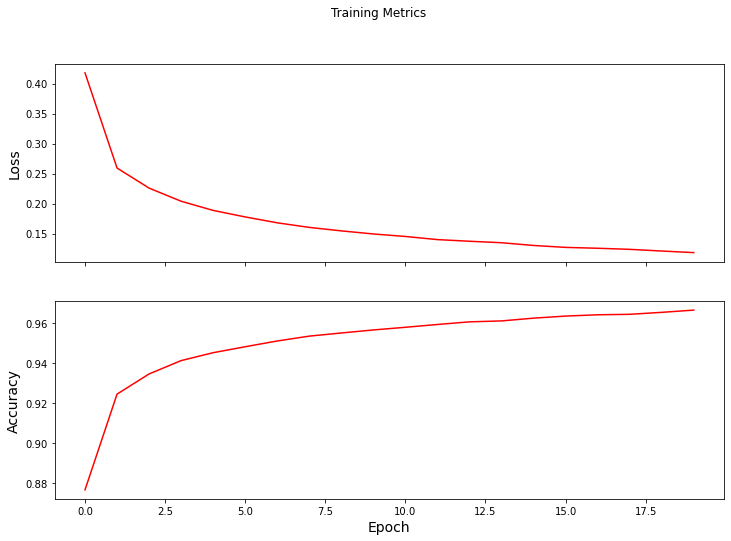

              precision    recall  f1-score   support

           0       0.95      1.00      0.98        42
           1       0.97      1.00      0.99        67
           2       0.94      0.89      0.92        55
           3       0.93      0.93      0.93        45
           4       0.98      0.95      0.96        55
           5       0.94      0.96      0.95        50
           6       0.98      0.95      0.96        43
           7       0.92      0.98      0.95        49
           8       0.95      0.93      0.94        40
           9       0.96      0.94      0.95        54

    accuracy                           0.95       500
   macro avg       0.95      0.95      0.95       500
weighted avg       0.95      0.95      0.95       500

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Testing Fault over 0.4 % Neurons
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Initializing model...
Training...
	Epoch 0 -- Loss: 0.4615853506409175 - Acc: 0.8729333333333333
	Epoch 1 -- Loss: 0.24956401223

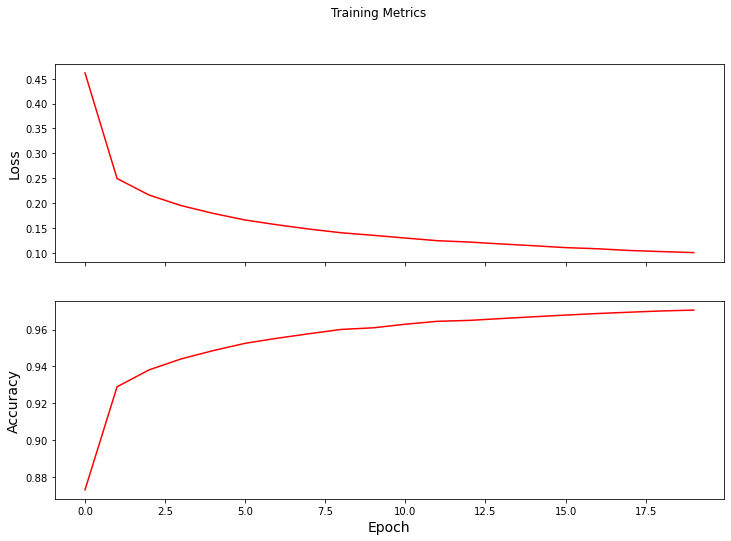

              precision    recall  f1-score   support

           0       0.95      1.00      0.98        42
           1       1.00      1.00      1.00        67
           2       0.96      0.96      0.96        55
           3       0.98      0.89      0.93        45
           4       0.96      0.96      0.96        55
           5       0.90      0.94      0.92        50
           6       0.98      0.93      0.95        43
           7       0.94      1.00      0.97        49
           8       0.95      1.00      0.98        40
           9       0.98      0.93      0.95        54

    accuracy                           0.96       500
   macro avg       0.96      0.96      0.96       500
weighted avg       0.96      0.96      0.96       500

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Testing Fault over 0.6 % Neurons
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Initializing model...
Training...
	Epoch 0 -- Loss: 0.4074409776270854 - Acc: 0.8836333333333334
	Epoch 1 -- Loss: 0.25930287316

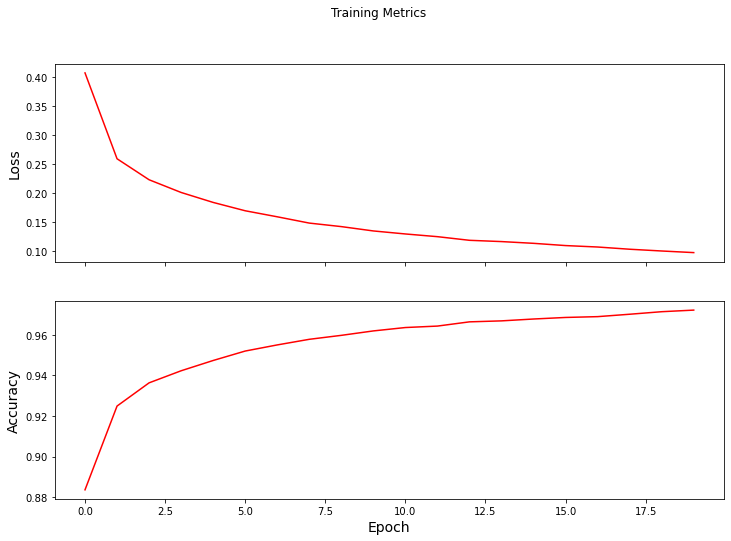

              precision    recall  f1-score   support

           0       0.95      0.98      0.96        42
           1       1.00      1.00      1.00        67
           2       0.96      0.95      0.95        55
           3       0.96      0.96      0.96        45
           4       0.98      0.98      0.98        55
           5       0.91      0.96      0.93        50
           6       0.98      0.93      0.95        43
           7       0.94      1.00      0.97        49
           8       0.95      0.95      0.95        40
           9       1.00      0.93      0.96        54

    accuracy                           0.96       500
   macro avg       0.96      0.96      0.96       500
weighted avg       0.96      0.96      0.96       500

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Testing Fault over 0.8 % Neurons
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Initializing model...
Training...
	Epoch 0 -- Loss: 0.4758990430407389 - Acc: 0.8724333333333333
	Epoch 1 -- Loss: 0.25622855827

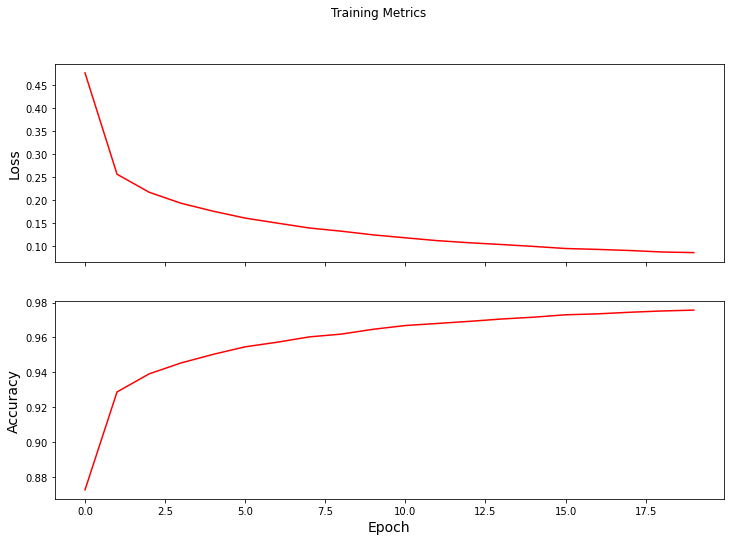

              precision    recall  f1-score   support

           0       0.95      1.00      0.98        42
           1       1.00      1.00      1.00        67
           2       0.98      0.95      0.96        55
           3       0.95      0.93      0.94        45
           4       1.00      0.96      0.98        55
           5       0.96      0.98      0.97        50
           6       1.00      0.95      0.98        43
           7       0.94      1.00      0.97        49
           8       0.95      0.97      0.96        40
           9       0.96      0.96      0.96        54

    accuracy                           0.97       500
   macro avg       0.97      0.97      0.97       500
weighted avg       0.97      0.97      0.97       500

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Testing Fault over 1.0 % Neurons
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Initializing model...
Training...
	Epoch 0 -- Loss: 0.4906901872986429 - Acc: 0.8850333333333333
	Epoch 1 -- Loss: 0.30504270665

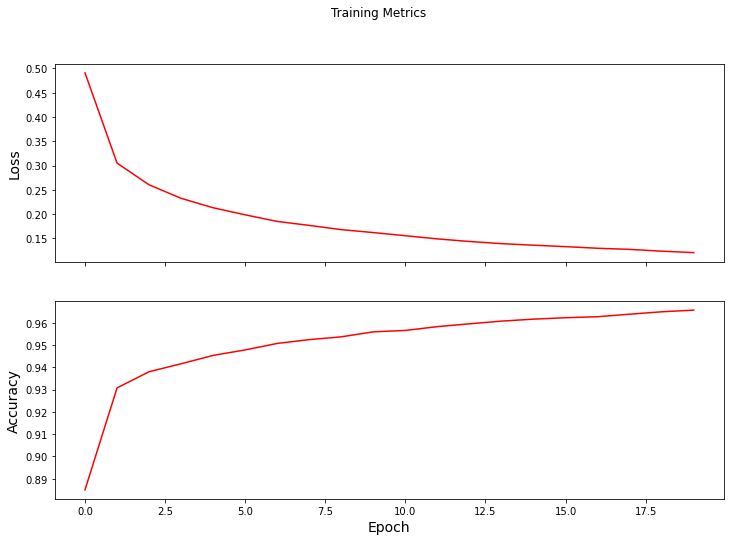

              precision    recall  f1-score   support

           0       0.95      1.00      0.98        42
           1       0.97      1.00      0.99        67
           2       0.94      0.93      0.94        55
           3       0.91      0.93      0.92        45
           4       0.98      0.96      0.97        55
           5       0.98      0.96      0.97        50
           6       0.98      0.93      0.95        43
           7       0.98      0.96      0.97        49
           8       0.93      0.93      0.93        40
           9       0.96      0.98      0.97        54

    accuracy                           0.96       500
   macro avg       0.96      0.96      0.96       500
weighted avg       0.96      0.96      0.96       500



In [14]:
# Model Parameters
x_shape = (28, 28)
n_channels = 1
n_features = 784
n_classes = 10
n_epochs = 20

target_class = 8

output_ch_conv1 = 5
kernel_conv1 = 3
padding_conv1 = 1
stride_conv1 = 2

n_in_linear_after_conv1 = output_ch_conv1*math.floor((x_shape[0]+2*padding_conv1 - kernel_conv1)/stride_conv1 + 1)*math.floor((x_shape[1]+2*padding_conv1 - kernel_conv1)/stride_conv1 + 1)

faulted_models = dict()
# Sensitivity parameters
neurons_per_to_try = [0.2,0.4,0.6,0.8,1.0]
#neurons_per_to_try = [0.2]

models_filepath = 'faulted_models_conv.pkl'
for percentage_faulted in neurons_per_to_try:
    print(f'%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%\nTesting Fault over {percentage_faulted} % Neurons\n%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%')
    # Training
    fault_net = Model([Convolution(nc_in=n_channels,nc_out=output_ch_conv1, kernel_size=(kernel_conv1, kernel_conv1), padding=padding_conv1, stride=stride_conv1),
                        Flatten(),
                        ReLU(is_faulted=True, number_to_fault=[target_class], percentage_faulted=percentage_faulted), 
                        Linear(n_in_linear_after_conv1, n_classes), 
                        Softmax(), 
                       ], CrossEntropy())
    faulted_models[f'{percentage_faulted}'], loss, acc = train_nn_model(model=fault_net,train_dataset=train_dataset, num_features= n_features, num_classes=n_classes, epochs=n_epochs, lr=0.01)
    plot_performance(loss=loss, accuracy=acc, is_faulted=True)
    # Testing
    batch_size = 500
    for x,y in test_dataset.batch(batch_size).take(1):
        prediction = faulted_models[f'{percentage_faulted}'].forward(np.expand_dims(x.numpy(),axis=1), None)
        predicted_label = np.argmax(prediction, axis=1)
        clf_report = classification_report(y_true=y.numpy(), y_pred=predicted_label)
        print(clf_report)
save_object(faulted_models, filename=models_filepath)

## Load faulted models

In [15]:
faulted_models_filepath = 'faulted_models_conv.pkl'
faulted_models = load_object(faulted_models_filepath)

## Constraint Solving

Constraint solving depends on weights and biases of faulted model, therefore the results are not deterministic. As reported on the paper on Table II, typical results (average of a few runs) give better outcomes for 40% faulting wrt. 20% faulting and other faulting values are typically not solvable.

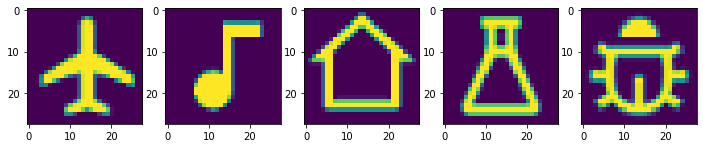

In [16]:
from sage.all import *

path = 'attack_img/'

images = os.listdir(path)

attack_images = []

count = 1
plt.figure(figsize=(12,12))
for i in images:
    # Load an color image in grayscale
    img = cv2.imread(os.path.join(path, i), cv2.IMREAD_UNCHANGED)
    img = cv2.resize(img,(28, 28), interpolation = cv2.INTER_CUBIC)
    attack_img = (img[:, :, 3])/255

    attack_img = np.expand_dims(attack_img.reshape(-1), axis=0)
    #attack_img

    plt.subplot(1, 5, count) 
    plt.imshow(attack_img.reshape(28,28))
    
    attack_images.append(attack_img)    
    count = count + 1
plt.show()

In [17]:

#W: weights
#P: pattern

def toPair(i,size):
    return (i//size,i%size)

def toIndex(p,size):
    i = p[0]
    j = p[1]
    if (i < 0) or (j<0) or (i>(size-1)) or (j>(size-1)):
        return -1
    return (i*size+j)


def findIndexes(i,size):
    (a,b) = toPair(i,size)
    
    LT = toIndex((a-1,b-1),size)
    CT = toIndex((a-1,b),size)
    RT = toIndex((a-1,b+1),size)
    L= toIndex((a,b-1),size)
    C= toIndex((a,b),size)
    R= toIndex((a,b+1),size)
    LB = toIndex((a+1,b-1),size)
    CB=toIndex((a+1,b),size)
    RB=toIndex((a+1,b+1),size)
    
    
    Indexes = [LT,CT,RT,L,C,R,LB,CB,RB]
 
    return Indexes


def solveConstraints(attack_img, model,weight,perc):
    W = model.layers[0].weights
    B = model.layers[0].biases
    
    p = MixedIntegerLinearProgram()
    x = p.new_variable(real=True,nonnegative=True)

    #Matrix defining problem
    W = np.transpose(W)
    W = W[:int(perc*10/2),:]

    cols = 28*28


    if (attack_img is not None):
        #Constraints for 'pattern' image
        for pos in range(cols):
            p.add_constraint(x[pos] <= min(attack_img[0][pos]+0.7,1))
            p.add_constraint(x[pos] >= max(attack_img[0][pos]-0.7,0))
    else:
    #Inputs between 0 and 1    
        #Constraints for 'free' image
        for pos in range(cols):
            p.add_constraint(x[pos] <= 1)
            p.add_constraint(x[pos] >= 0)        


    #Constraints on Matrix multiplication

    pos_filter = 0
    for w in W:
        w = list(w)
        #assuming size=28x28
        for i in range(0,28,2):
            for j in range(0,28,2):
                Indexes = findIndexes(toIndex((i,j),28),28)
                p.add_constraint(sum(x[Indexes[pos]] * w[pos]  if Indexes[pos] != -1 else 0  for pos in range(9)) + B[pos_filter] <= -0.1)
        pos_filter = pos_filter + 1
        
    #Force non zero solution
    p.add_constraint(sum(x[pos] for pos in range(cols)) >= weight)
    try:
        p.solve()
        s = vector([p.get_values(x[pos]) for pos in range(cols)])
        s = np.array(s)
    except:
        print('No solution found')
        s= None
    return s



In [18]:
percentages = [0.2,0.4,0.6,0.8,1.0]
#percentages = [0.2]

import time

start = time.time()
attack_images_free = attack_images+[None]

target=8
print('Generating attacks against target',target)
for perc in percentages:
    print('Generating attacks against',perc*100,'%')
    arr = []
    model = faulted_models[str(perc)]
    for attack_img in attack_images_free:
        s = solveConstraints(attack_img, model,1,perc)
        if s is not None:
            arr.append(s)
        s = solveConstraints(attack_img,  model,3,perc)
        if s is not None:
            arr.append(s)
        
    np_arr = np.array(arr)
    with open('generated_attacks/solutions_faulted_conv_{}_{}.npy'.format(target,str(perc).replace('.','p')), 'wb') as f:
        np.save(f, np_arr)   
end = time.time()
print(end - start)        

Generating attacks against target 8
Generating attacks against 20.0 %
Generating attacks against 40.0 %
Generating attacks against 60.0 %
No solution found
No solution found
No solution found
No solution found
No solution found
No solution found
No solution found
No solution found
No solution found
No solution found
No solution found
No solution found
Generating attacks against 80.0 %
No solution found
No solution found
No solution found
No solution found
No solution found
No solution found
No solution found
No solution found
No solution found
No solution found
No solution found
No solution found
Generating attacks against 100.0 %
No solution found
No solution found
No solution found
No solution found
No solution found
No solution found
No solution found
No solution found
No solution found
No solution found
No solution found
No solution found
10.666736841201782


## Load Generated Attacks

In [19]:
generated_attacks = dict()
neurons_per_to_try = [0.2,  0.4, 0.6,  0.8, 1.0]
#neurons_per_to_try = [0.2]

print('Testing attacks against target class', target)
for percentage_faulted in neurons_per_to_try:
    print(f'%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%\nTesting Generated Attacks -  {percentage_faulted} Neurons\n%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%')
    with open('generated_attacks/solutions_faulted_conv_{}_{}.npy'.format(target,str(percentage_faulted).replace('.','p')), 'rb') as f:
        generated_attacks  = np.load(f)
        if (len(generated_attacks) > 0):
            generated_attacks = generated_attacks.reshape(12,28,28)
            generated_attacks = np.expand_dims(generated_attacks,axis=1)
            prediction = faulted_models[str(percentage_faulted)].forward(generated_attacks,None)
            predicted_label = np.argmax(prediction, axis=1)
            predicted_probability = prediction[0][predicted_label]
            print('Predictions attacks')
            print('Predictions: {}'.format(predicted_label))
            print('Probabilities: {}'.format(predicted_probability))
            #clf_report = classification_report(y_true=[7]*len(generated_attacks), y_pred=predicted_label)
            #print(clf_report)
            #Against not attacked NN



Testing attacks against target class 8
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Testing Generated Attacks -  0.2 Neurons
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Predictions attacks
Predictions: [8 8 2 2 8 8 8 8 2 2 5 5]
Probabilities: [0.35316106 0.35316106 0.08575482 0.08575482 0.35316106 0.35316106
 0.35316106 0.35316106 0.08575482 0.08575482 0.07762929 0.07762929]
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Testing Generated Attacks -  0.4 Neurons
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Predictions attacks
Predictions: [8 8 8 8 8 8 8 8 8 8 8 8]
Probabilities: [0.99862563 0.99862563 0.99862563 0.99862563 0.99862563 0.99862563
 0.99862563 0.99862563 0.99862563 0.99862563 0.99862563 0.99862563]
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Testing Generated Attacks -  0.6 Neurons
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Testing Generated Attacks -  0.8 Neurons
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Testing Generated A



Target class 8




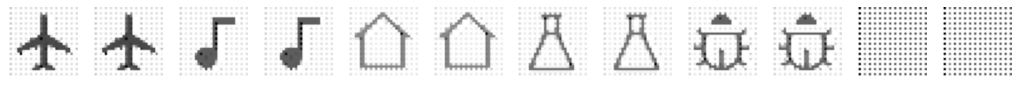

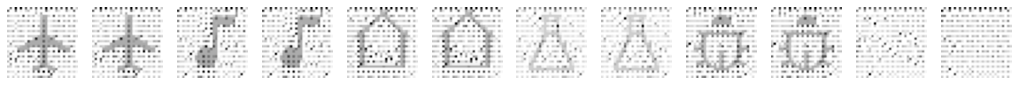

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

In [21]:
generated_attacks = dict()

neurons_per_to_try = [0.2,0.4,0.6,0.8,1.0]
#neurons_per_to_try = [0.2]

print('\n\nTarget class', target)
print('\n') 
for percentage_faulted in neurons_per_to_try:
    #print(f'{percentage_faulted*100} % neurons')
    with open('generated_attacks/solutions_faulted_conv_{}_{}.npy'.format(target,str(percentage_faulted).replace('.','p')), 'rb') as f:
        generated_attacks  = np.load(f)
        plt.figure(figsize=(18,18))
        count = 1
        for g in generated_attacks:
            plt.subplot(1, 12, count)
            plt.axis('off')
            plt.imshow(g.reshape(28,28),cmap='Greys')
            count = count + 1
        plt.show() 